In [1]:
%run init_notebookspace.py

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\memoire1\data


In [2]:
import numpy as np

In [3]:
import numpy,math
import matplotlib.pyplot as plt
import random as random

random.seed(1)  # set random seed.

# Draw random samples from Salpeter IMF.
# N     ... number of samples.
# alpha ... power-law index.
# M_min ... lower bound of mass interval.
# M_max ... upper bound of mass interval.
def sampleFromSalpeter(N, alpha, M_min, M_max):
    # Convert limits from M to logM.
    log_M_Min = math.log(M_min)
    log_M_Max = math.log(M_max)
    # Since Salpeter SMF decays, maximum likelihood occurs at M_min
    maxlik = math.pow(M_min, 1.0 - alpha)

    # Prepare array for output masses.
    Masses = []
    # Fill in array.
    while (len(Masses) < N):
        # Draw candidate from logM interval.
        logM = random.uniform(log_M_Min,log_M_Max)
        M    = math.exp(logM)
        # Compute likelihood of candidate from Salpeter SMF.
        likelihood = math.pow(M, 1.0 - alpha)
        # Accept randomly.
        u = random.uniform(0.0,maxlik)
        if (u < likelihood):
            Masses.append(M)
    return Masses

In [4]:
# Define logarithmic likelihood function.
# params ... array of fit params, here just alpha
# D      ... sum over log(M_n)
# N      ... number of data points.
# M_min  ... lower limit of mass interval
# M_max  ... upper limit of mass interval
def evaluateLogLikelihood(params, D, N, M_min, M_max):
    alpha = params[0]  # extract alpha
    # Compute normalisation constant.
    c = (1.0 - alpha)/(math.pow(M_max, 1.0-alpha)
                        - math.pow(M_min, 1.0-alpha))
    # return log likelihood.
    return N*math.log(c) - alpha*D

# Generate toy data.
N      = 1000000  # Draw 1 Million stellar masses.
alpha  = 2.35
M_min  = 1.0
M_max  = 100.0
Masses = sampleFromSalpeter(N, alpha, M_min, M_max)
LogM   = numpy.log(numpy.array(Masses))
D      = numpy.mean(LogM)*N

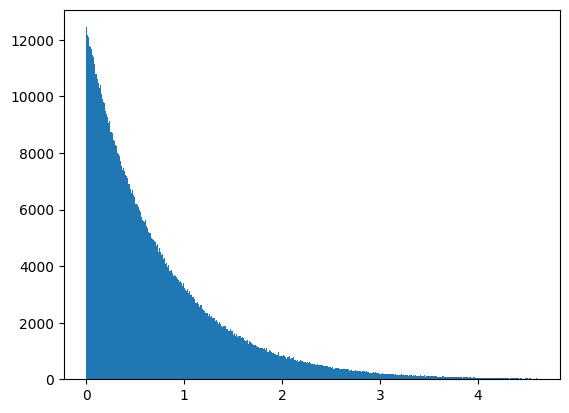

In [5]:
plt.hist(LogM, bins=500);

In [11]:
from scipy.stats import gamma, norm, beta

In [ ]:
norm

In [10]:
sc(old_alpha, 0.005)

array([2.35064761])

In [6]:
# initial guess for alpha as array.
guess = [3.0]
# Prepare storing MCMC chain as array of arrays.
A = [guess]
# define stepsize of MCMC.
stepsizes = [0.005]  # array of stepsizes
accepted  = 0.0

# Metropolis-Hastings with 10,000 iterations.
for n in range(10000):
    old_alpha  = A[len(A)-1]  # old parameter value as array
    
    old_loglik = evaluateLogLikelihood(old_alpha, D, N, M_min, M_max)
    # old_loglik = stats.multivariate_normal.logpdf(old_alpha, rv.mean(), rv.std()**2)
    
    # Suggest new candidate from Gaussian proposal distribution.
    new_alpha = numpy.zeros([len(old_alpha)])
    for i in range(len(old_alpha)):
        # Use stepsize provided for every dimension.
        # new_alpha[i] = random.gauss(old_alpha[i], stepsizes[i])
        new_alpha[i] = random.gauss(old_alpha[i], stepsizes[i])
        
    new_loglik = evaluateLogLikelihood(new_alpha, D, N, M_min, M_max)
    # new_loglik = stats.multivariate_normal.logpdf(new_alpha, rv.mean(), rv.std()**2)
    
    # Accept new candidate in Monte-Carlo fashing.
    if (new_loglik > old_loglik):
        A.append(new_alpha)
        accepted = accepted + 1.0  # monitor acceptance
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_loglik - old_loglik)):
            A.append(new_alpha)
            accepted = accepted + 1.0  # monitor acceptance
        else:
            A.append(old_alpha)

print(f"Acceptance rate = {str(accepted/10000.0)}")

Acceptance rate = 0.3318


In [7]:
A

[[3.0],
 [3.0],
 [3.0],
 array([2.99438379]),
 array([2.99438379]),
 array([2.98972017]),
 array([2.98972017]),
 array([2.98864214]),
 array([2.98586677]),
 array([2.98442709]),
 array([2.98205973]),
 array([2.98205973]),
 array([2.98205973]),
 array([2.98205973]),
 array([2.98129968]),
 array([2.97999219]),
 array([2.97820363]),
 array([2.97820363]),
 array([2.97820363]),
 array([2.9718658]),
 array([2.9718658]),
 array([2.9718658]),
 array([2.96729231]),
 array([2.96729231]),
 array([2.96492377]),
 array([2.95998151]),
 array([2.95122779]),
 array([2.94501254]),
 array([2.94501254]),
 array([2.94253073]),
 array([2.93861248]),
 array([2.93861248]),
 array([2.93861248]),
 array([2.91733596]),
 array([2.913565]),
 array([2.913565]),
 array([2.91211069]),
 array([2.91211069]),
 array([2.91211069]),
 array([2.91211069]),
 array([2.91211069]),
 array([2.90784507]),
 array([2.90044984]),
 array([2.89800401]),
 array([2.89332486]),
 array([2.89156167]),
 array([2.89156167]),
 array([2.89103

Mean: 2.350621558298771
Sigma: 0.0014322454830060377


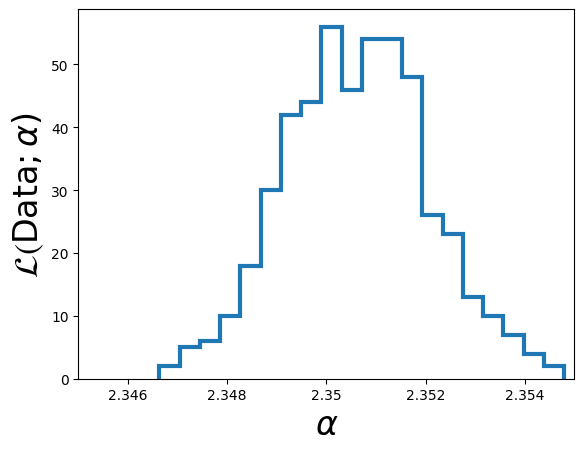

In [69]:
# Discard first half of MCMC chain and thin out the rest.
Clean = []
for n in range(5000,10000):
    if (n % 10 == 0):
        Clean.append(A[n][0])

# Print Monte-Carlo estimate of alpha.
print(f"Mean: {str(numpy.mean(Clean))}")
print(f"Sigma: {str(numpy.std(Clean))}")

plt.figure(1)
plt.hist(Clean, 20, histtype='step', lw=3)
plt.xticks([2.346,2.348,2.35,2.352,2.354],
           [2.346,2.348,2.35,2.352,2.354])
plt.xlim(2.345,2.355)
plt.xlabel(r'$\alpha$', fontsize=24)
plt.ylabel(r'$\cal L($Data$;\alpha)$', fontsize=24)
plt.savefig('example-MCMC-results.png')
plt.show()